<center><img src="https://i.imgur.com/YNtjmbq.png" width="800"></center> 

<div class="alert alert-info" role="alert">
    
## Data para la sesión

Para esta sesión, los datos puedes descargarlos en _tu_ carpeta **data** desde este [enlace](https://drive.google.com/drive/folders/1I48Vani9iBX-AdEbXH-qCsbinH2t8oEj?usp=sharing).
</div>



# Práctica 4 – Visualización de Propiedades de la red

[VosViewer](https://www.vosviewer.com/) es un servicio de analisis de datos bibliográficos, la data que usaremos ha sido preparado por ellos. De la carpeta de datos para la sesión, usemos el de tipo **graphml**:

In [1]:
import networkx as nx

journal=nx.read_graphml("data/journal.graphml")

Esta es una red que representa relaciones de citado entre journals. No es la red total, lo que se tiene es:

In [2]:
len(journal.edges), len(journal.nodes)

(4112, 232)

Esta red viene con atributos en los nodos y enlaces:

In [3]:
# en los nodos
[x.keys() for x in journal.nodes.values()][0]

dict_keys(['label', 'description', 'cluster', 'x', 'y', 'issn', 'citations'])

In [4]:
# en los enlaces
[x.keys() for x in journal.edges.values()][0]

dict_keys(['weight', 'id'])

Esta es una red que indica el patron de citación entre revistas, por lo que es de tipo dirigido:

In [5]:
nx.is_directed(journal)

True

Verifiquemos algunas particularidades:
1. ¿Tendremos algun journal  que no siga a otro ni sea seguido por otro?

In [6]:
list(nx.isolates(journal))

[]

2. ¿Cuál es su nivel de reciprocidad?

In [7]:
nx.overall_reciprocity(journal)

0.0

Esto indica que ningun nodo recibe un link de otro. Aqui el detalle:

In [8]:

import pandas as pd
pd.DataFrame.from_dict(nx.reciprocity(journal,nodes=journal.nodes),orient='index').value_counts()

0  
0.0    232
Name: count, dtype: int64

3. ¿Cada nodo puede conectarse con otro nodo? De lo anterior ya sabemos que no, por lo que no es **strongly connected**:

In [9]:
nx.is_strongly_connected(journal)

False

Asi, hay tantos componentes conectados como nodos.

In [10]:
nx.number_strongly_connected_components(journal)

232

4. ¿Que tant cerca a una rede completamente conectada está nuestra red?

In [11]:
nx.density(journal)

0.0767278698313181

La **densidad** es muy baja, lo cuál corrobora lo hayado.

# Gráficas

## Hairballs

El hairball es simplemente una red con los nodos ubicados al azar. Grafiquemos la red, coloreando los nodos según el atributo "cluster" que asignó **vosviewer**:

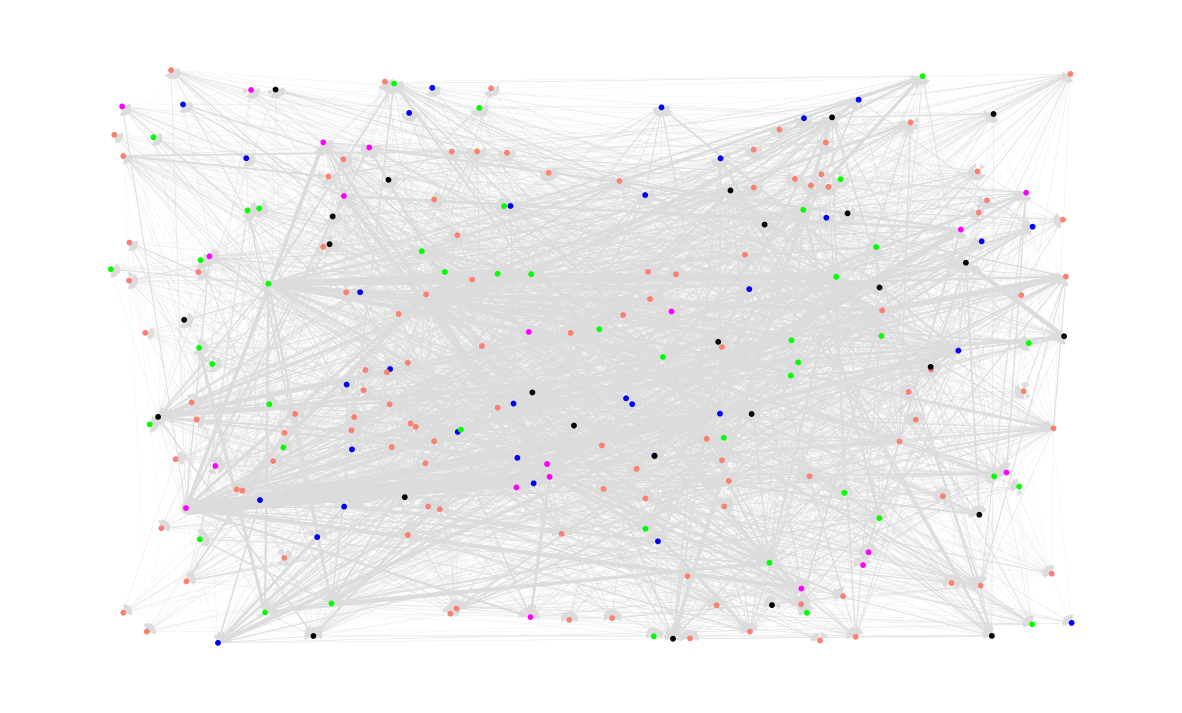

In [12]:
weights = list(nx.get_edge_attributes(journal,'weight').values())
weights=[10*(w/max(weights)) for w in weights]


from matplotlib import colors
myColMap = colors.ListedColormap([ 'salmon', 'lime', 'blue', 'black','magenta'])

ATTRIBUTE_NAME = 'cluster'
colors = list(nx.get_node_attributes(journal,ATTRIBUTE_NAME).values())

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
plot_options = {'pos':nx.random_layout(journal),
                "node_size": 10,
                "with_labels": False,
                'width':weights,
                'edge_color':'gainsboro',
                'cmap':myColMap,
                'node_color':colors}

nx.draw_networkx(journal, ax=ax, **plot_options)

## Force-Directed

Esta familia de layouts ayuda graficar los nodos mezclando atracción y repulsion.

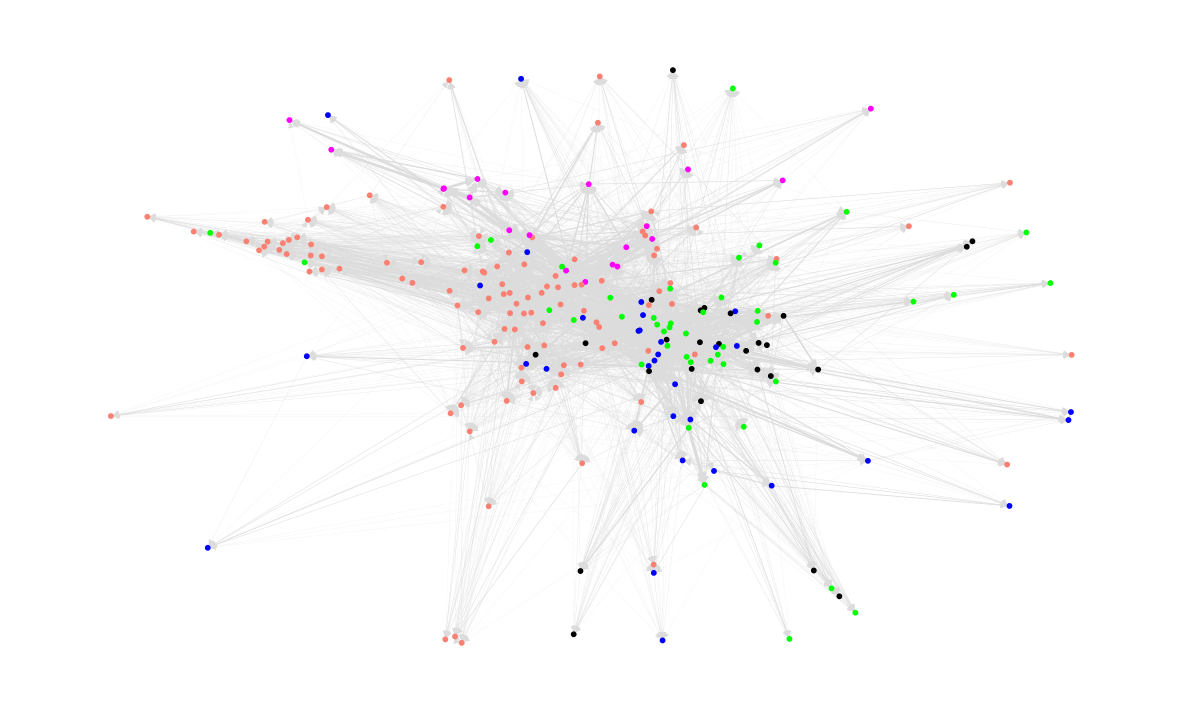

In [13]:


fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
plot_options = {'pos':nx.spring_layout(journal),
                "node_size": 10,
                "with_labels": False,
                'width':weights,
                'edge_color':'gainsboro',
                'cmap':myColMap,
                'node_color':colors}
nx.draw(journal, ax=ax, **plot_options)

## Custom

Vosviewer incluye unas coordenadas en su red, las cuáles sirven para resaltar una estructura de su interés:

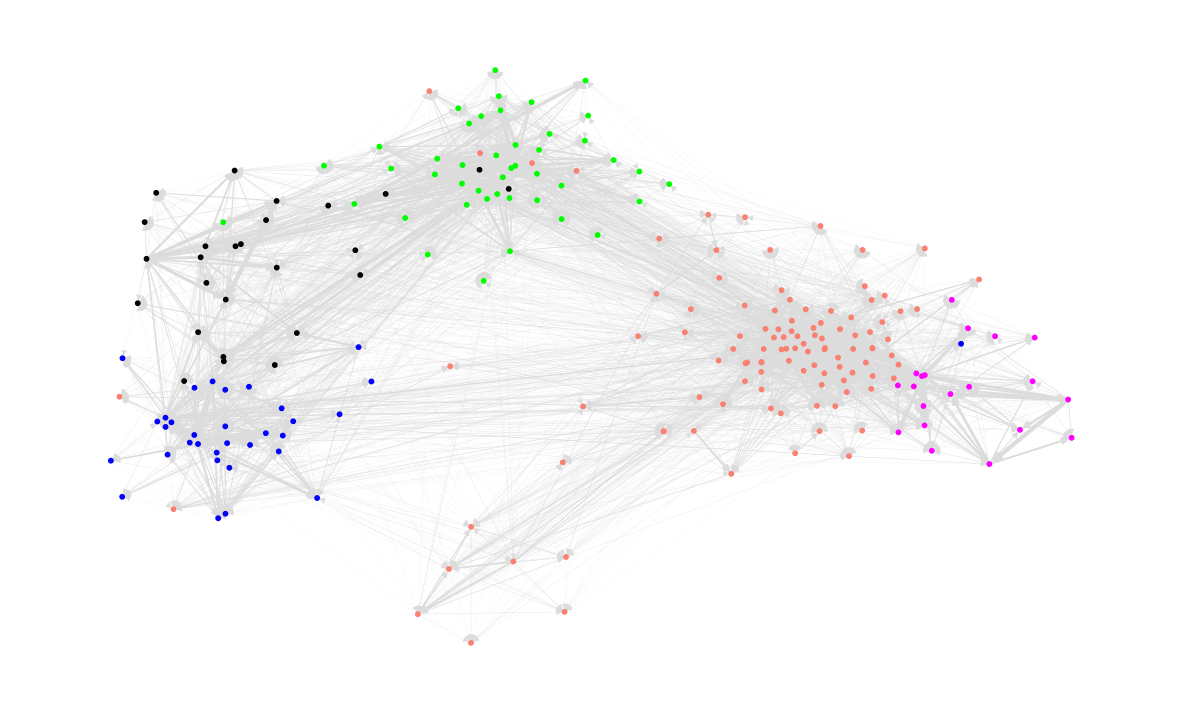

In [14]:
nodePositions_vox={k:(x,y) for k,x,y in zip(list(journal.nodes),
                                            nx.get_node_attributes(journal, 'x').values(),
                                            nx.get_node_attributes(journal, 'y').values())}


fig, ax = plt.subplots(figsize=(15, 9))
plot_options = {'pos':nodePositions_vox,
                "node_size": 10,
                "with_labels": False,
                'width':weights,
                'edge_color':'gainsboro',
                'cmap':myColMap,
                'node_color':colors}
ax.axis("off")
nx.draw_networkx(journal, ax=ax, **plot_options)

Como se ve, este layout sirve para diferenciar tipos de revistas.

## Propiedades a visualizar

### <div class="alert alert-success" role="alert">Grado (degree)</div>

De esa red podemos saber:
1. ¿Quíen tiene más vecinos?
   
    a. conectados a él: 

In [15]:
(sorted(journal.in_degree, key=lambda item: item[1], reverse=True))[0]

('115', 38)

    b. con los que él se conecta:

In [16]:
(sorted(journal.out_degree, key=lambda item: item[1], reverse=True))[0]

('2', 114)

Podemos ubicar estos nodos particulares:

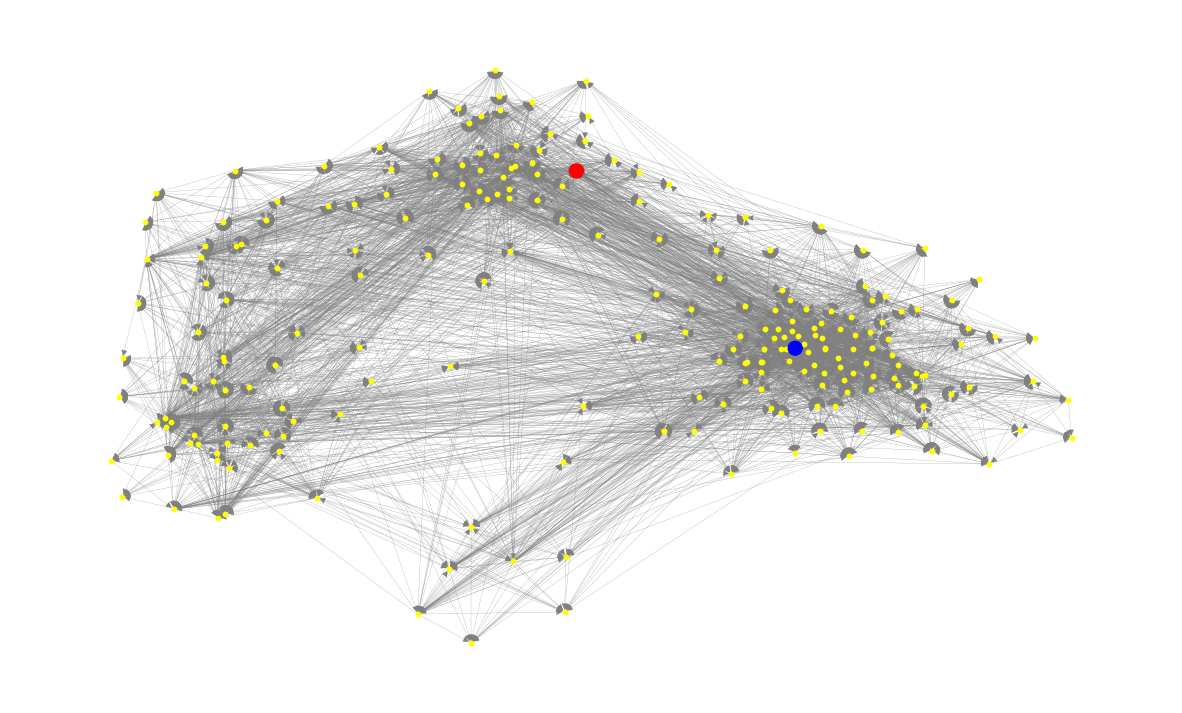

In [17]:
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
plot_options = {"node_size": 10, "with_labels": False, "width": 0.15,'edge_color':'grey','node_color':'yellow'}

nx.draw_networkx(journal, pos=nodePositions_vox, ax=ax, **plot_options)
nx.draw_networkx_nodes(journal,nodePositions_vox,nodelist=['115','2'],ax=ax,node_color=['r','b'], node_size=100)

Guardemos todos los valores anteriores:

In [18]:
import pandas as pd

indegree=pd.Series(dict(journal.in_degree()),name='indegree')
outdegree=pd.Series(dict(journal.out_degree()),name='outdegree')

In [19]:
journal.nodes(data=True)['1']

{'label': 'eur j oper res',
 'description': 'EUROPEAN JOURNAL OF OPERATIONAL RESEARCH',
 'cluster': 3,
 'x': -526.2414,
 'y': 362.03247,
 'issn': '0377-2217',
 'citations': 892}

Usemos esos valores para variar tamaño de nodos:

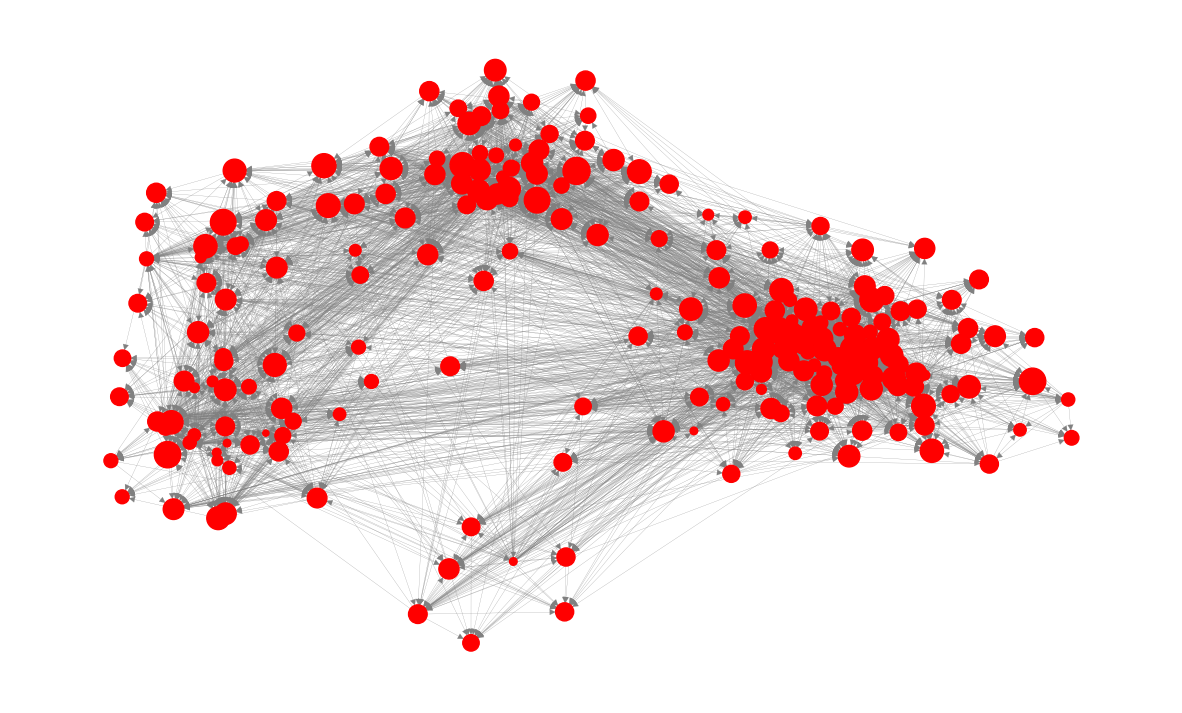

In [20]:
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
plot_options = {"node_size": 10*indegree.values, 
                "with_labels": False, "width": 0.15,'edge_color':'grey','node_color':'red'}

nx.draw_networkx(journal, pos=nodePositions_vox, ax=ax, **plot_options)

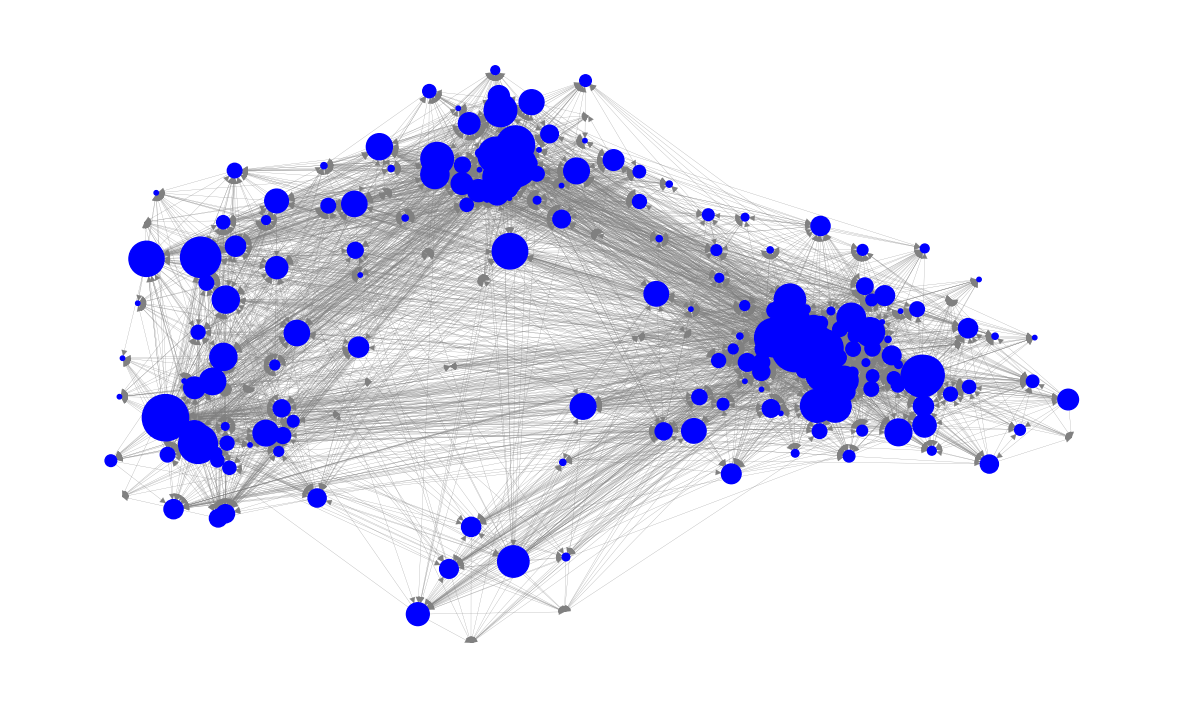

In [21]:
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
plot_options = {"node_size": 10*outdegree.values,
                "with_labels": False, "width": 0.15,'edge_color':'grey','node_color':'blue'}

nx.draw_networkx(journal, pos=nodePositions_vox, ax=ax, **plot_options)

### El degree 0

Los nodos de con indegree o outdegree de grado zero son interesantes. Los primeros son puertas de acceso, los segundo puertas de salida.

In [22]:
zeroDegree=pd.Series(1*(indegree==0) + 2*(outdegree==0),name='zerodegree')

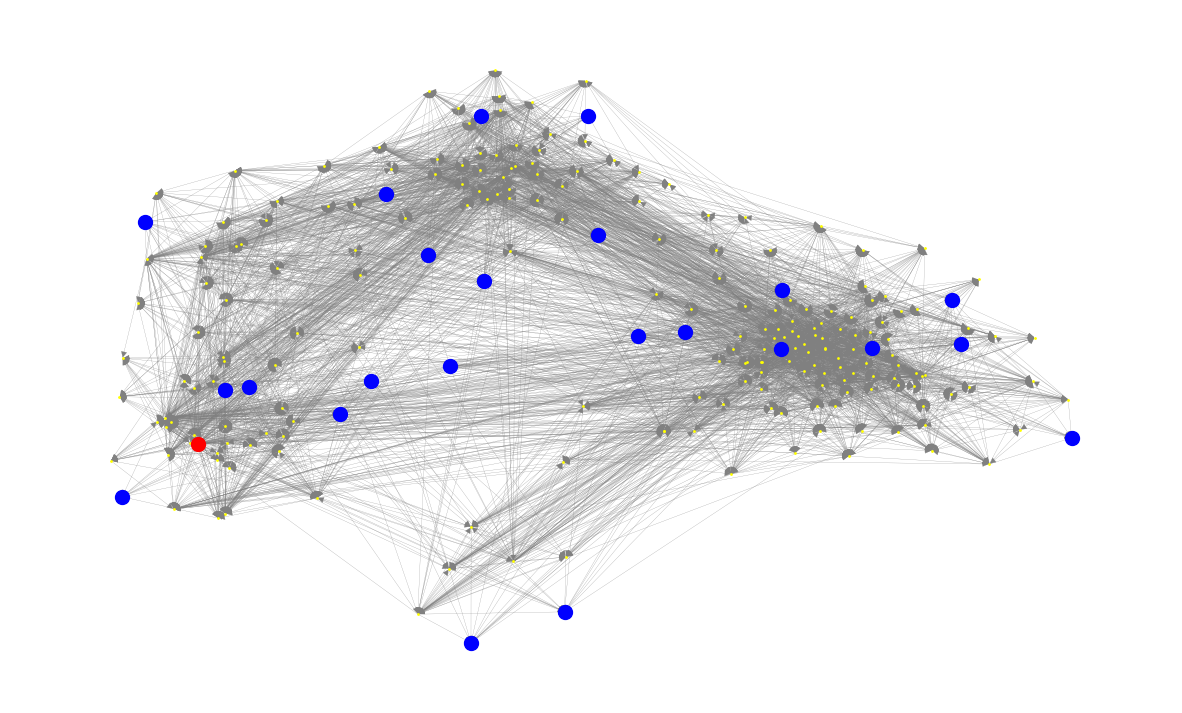

In [23]:
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
plot_options = {"node_size": 1, "with_labels": False, "width": 0.15,'edge_color':'grey','node_color':'yellow'}

nx.draw_networkx(journal, pos=nodePositions_vox, ax=ax, **plot_options)
nx.draw_networkx_nodes(journal,nodePositions_vox,nodelist=zeroDegree[zeroDegree==1].index,ax=ax,node_color=['r'], node_size=100)
nx.draw_networkx_nodes(journal,nodePositions_vox,nodelist=zeroDegree[zeroDegree==2].index,ax=ax,node_color=['b'], node_size=100)

### <div class="alert alert-success" role="alert">CENTRALIDAD</div>

En sesiones anteriores vimos que la ubicación de los nodos les da cierta centralidad o relevancia en la red:

In [24]:
closeness_centrality_in_dict=nx.closeness_centrality(journal,distance=None)
closeness_centrality_out_dict=nx.closeness_centrality(journal.reverse(),distance=None)
betweenness_centrality_dict=nx.betweenness_centrality(journal)

closeness_centrality_in= pd.Series(closeness_centrality_in_dict,name='INcloseness')
closeness_centrality_out= pd.Series(closeness_centrality_out_dict,name='OUTcloseness')
betweenness_centrality= pd.Series(betweenness_centrality_dict,name='betweenness')

Grafiquemos:

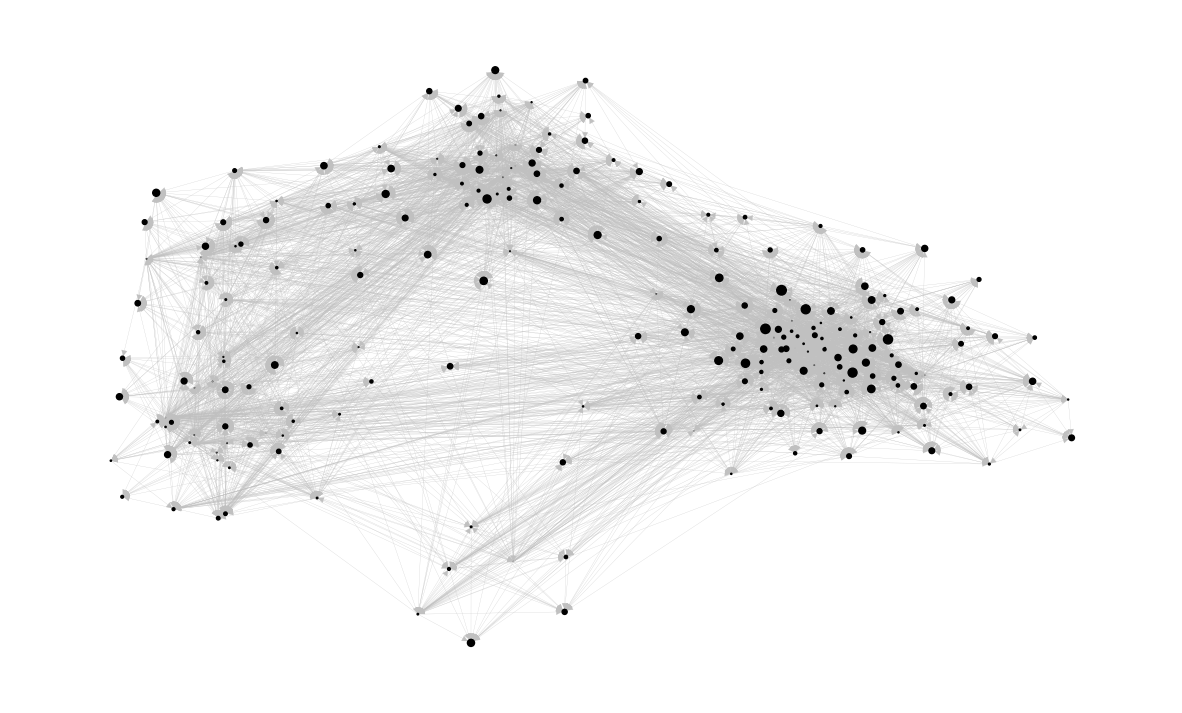

In [25]:
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
plot_options = {"node_size": (10*closeness_centrality_in.values)**3,
                "with_labels": False, "width": 0.15,
                'edge_color':'silver','node_color':'k'}

nx.draw_networkx(journal, pos=nodePositions_vox, ax=ax, **plot_options)

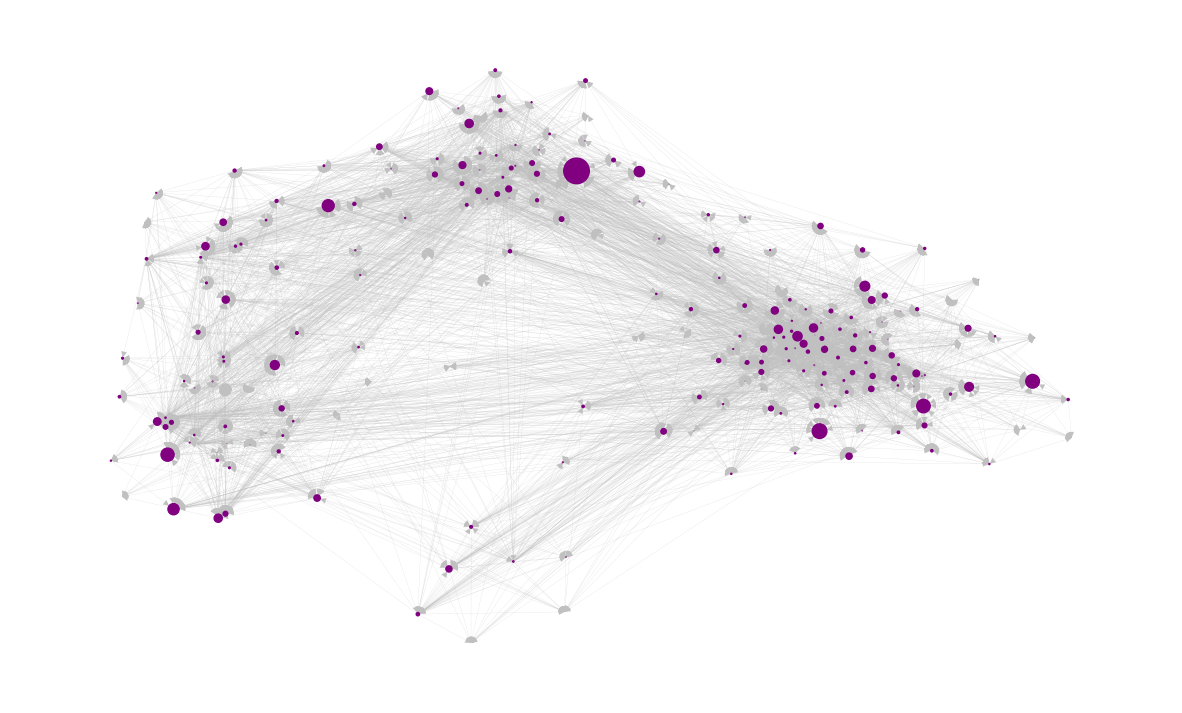

In [26]:
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
plot_options = {"node_size": (1000*betweenness_centrality.values)**2,
                "with_labels": False,
                "width": 0.1,'edge_color':'silver','node_color':'purple'}

nx.draw_networkx(journal, pos=nodePositions_vox, ax=ax, **plot_options)

In [27]:
node_cut=nx.minimum_node_cut(journal)
edge_cut=nx.minimum_edge_cut(journal)
len(node_cut),len(edge_cut)

(0, 0)

### <div class="alert alert-success" role="alert">LINK-BASED</div>

Vimos anteriormente que el patrón de la dirección de los enlaces permite visualizar nodos clave, en el sentido de tener 'contenido' atractivo.

In [28]:
h_dict,a_dict=nx.hits(journal)
pagerank_dict=nx.pagerank(journal)

HITS_hubs=pd.Series(h_dict,name='HITS_hubs')
HITS_authorities=pd.Series(a_dict,name="HITS_authorities")
Pagerank=pd.Series(pagerank_dict,name='Pagerank')

pd.concat([HITS_hubs,HITS_authorities,Pagerank],axis=1)

HITS_hubs  HITS_authorities  Pagerank
1     0.033161         -0.000000  0.001480
2     0.083688          0.000103  0.001483
3     0.182790          0.006601  0.001535
4     0.064329          0.002634  0.001495
5     0.030963          0.012210  0.001650
..         ...               ...       ...
228   0.000013          0.000891  0.017221
229   0.000013          0.000674  0.012053
230  -0.000000          0.001219  0.005440
231   0.000019          0.000502  0.028470
232  -0.000000          0.000506  0.052718

[232 rows x 3 columns]

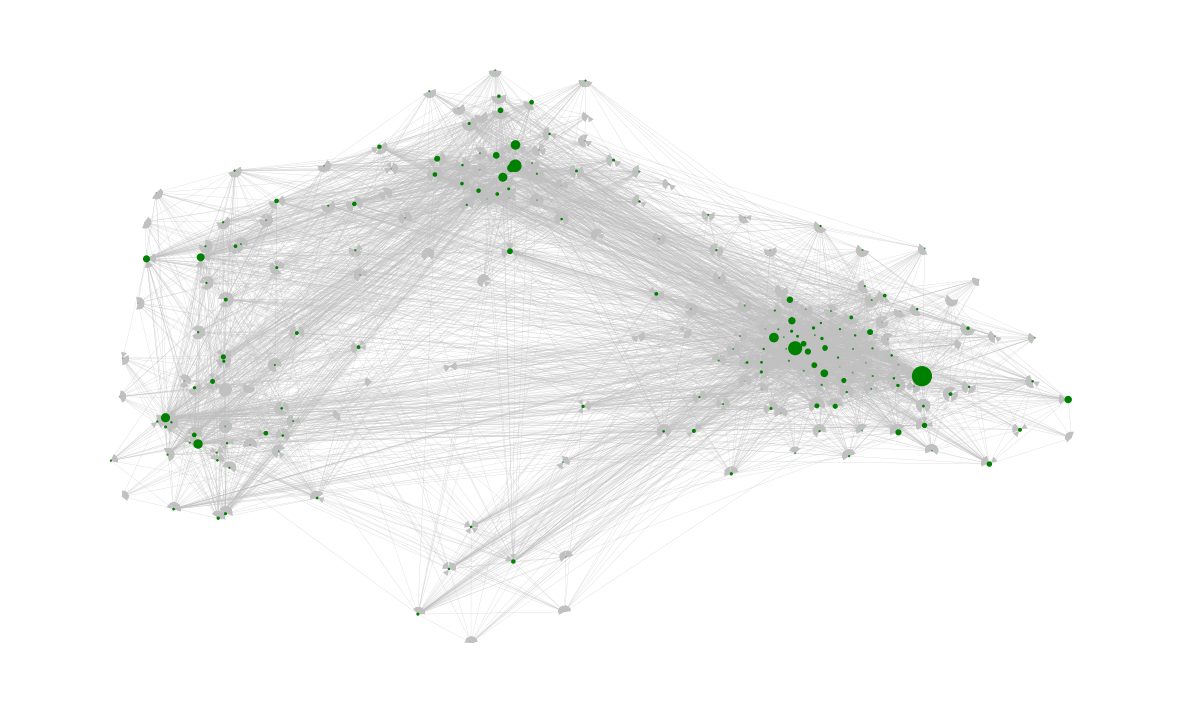

In [29]:
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
plot_options = {"node_size": 1000*HITS_hubs.values, "with_labels": False,
                "width": 0.15,'edge_color':'silver','node_color':'green'}

nx.draw_networkx(journal, pos=nodePositions_vox, ax=ax, **plot_options)

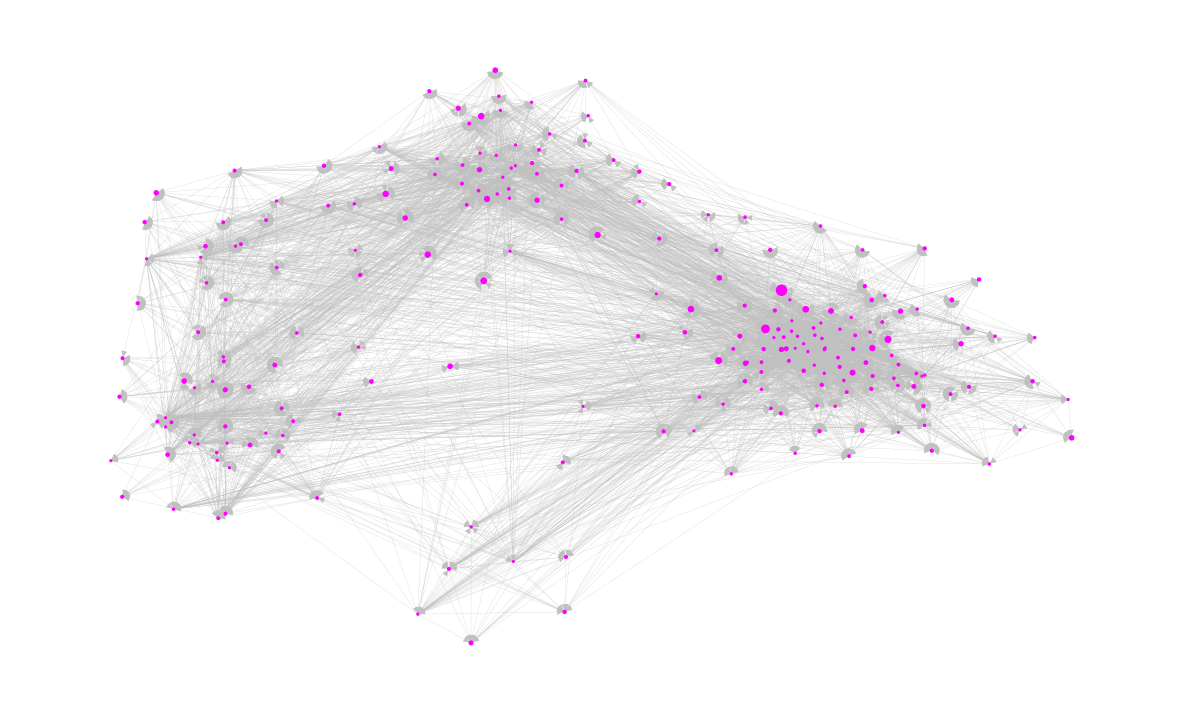

In [30]:
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
plot_options = {"node_size": 1000*Pagerank.values, "with_labels": False,
                "width": 0.15,'edge_color':'silver','node_color':'magenta'}

nx.draw_networkx(journal, pos=nodePositions_vox, ax=ax, **plot_options)

# Usemos Gephi

1. Abramos el mismo archivo en Gephi.
2. Pidamos los estadísticos:  
* Average Degree
* Network Diamater
* HIT
* PageRank

3. Selecciones "Appearance". Desde ahí, asignemos diferentes colores o tamaños a los nodos basados en los valores calculados.

<figure>
<img src="https://github.com/MAGALLANESJoseManuel/MGPIT_Pol748_Redes_4/blob/main/pics/gephi_appearance.png?raw=true" style="width:50%">
<figcaption align = "center"> Figura 1. Menú de cambio de apariencia en Gephi. 
 </figcaption>
 Fuente: Autor.
</figure>

4. Si va alterar el tamaño, preste atención a los splines:
<figure>
<img src="https://github.com/MAGALLANESJoseManuel/MGPIT_Pol748_Redes_4/blob/main/pics/gephi_spline.png?raw=true" style="width:50%">
<figcaption align = "center"> Figura 2. Menú de Splines en Gephi. 
 </figcaption>
 Fuente: Autor.
</figure>



<div class="alert-success">

## Ejercicio

Abra en Gephi el archivo SeattleTop, calcule los estadístico vistos en esta sesión, y úselos para graficar.